<a href="https://colab.research.google.com/github/paryagsahni1845/deeplearning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from collections import Counter
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
dataset = load_dataset("imdb")
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
def simple_tokenizer(text):
    return text.lower().split()

counter = Counter()
for text in dataset["train"]["text"]:
    counter.update(simple_tokenizer(text))

# limit vocab to top 10000 tokens
vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.most_common(10000))}
vocab["<pad>"] = 0
vocab["<unk>"] = 1

def text_pipeline(x):
    return [vocab.get(token, vocab["<unk>"]) for token in simple_tokenizer(x)]

def label_pipeline(y):
    return float(y)


In [ ]:
def collate_batch(batch):
    text_list, label_list = [], []
    for item in batch:
        text_list.append(torch.tensor(text_pipeline(item["text"]), dtype=torch.long))
        label_list.append(label_pipeline(item["label"]))
    text_list = pad_sequence(text_list, padding_value=vocab["<pad>"])
    label_list = torch.tensor(label_list, dtype=torch.float32)
    return text_list.to(device), label_list.to(device)


In [ ]:
train_dataloader = DataLoader(dataset["train"], batch_size=64, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(dataset["test"], batch_size=64, shuffle=False, collate_fn=collate_batch)


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)        # [seq_len, batch, emb_dim]
        output, hidden = self.rnn(embedded)    # hidden: [1, batch, hidden_dim]
        return self.fc(hidden.squeeze(0))      # [batch, output_dim]


In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
print(model)


RNN(
  (embedding): Embedding(10002, 100)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters())

def binary_accuracy(preds, y):
    rounded = torch.round(torch.sigmoid(preds))
    correct = (rounded == y).float()
    return correct.sum() / len(correct)


In [ ]:
def train_epoch(model, dataloader):
    model.train()
    epoch_loss, epoch_acc = 0, 0
    for text, labels in dataloader:
        optimizer.zero_grad()
        preds = model(text).squeeze(1)
        loss = criterion(preds, labels)
        acc = binary_accuracy(preds, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    epoch_loss, epoch_acc = 0, 0
    with torch.no_grad():
        for text, labels in dataloader:
            preds = model(text).squeeze(1)
            loss = criterion(preds, labels)
            acc = binary_accuracy(preds, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)


In [ ]:
for epoch in range(3):  # keep small for demo
    train_loss, train_acc = train_epoch(model, train_dataloader)
    test_loss, test_acc = evaluate(model, test_dataloader)
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")
    print("-" * 40)


Epoch 1
Train Loss: 0.703 | Train Acc: 49.73%
Test Loss: 0.700 | Test Acc: 49.46%
----------------------------------------
Epoch 2
Train Loss: 0.697 | Train Acc: 50.18%
Test Loss: 0.698 | Test Acc: 49.47%
----------------------------------------
Epoch 3
Train Loss: 0.696 | Train Acc: 50.01%
Test Loss: 0.693 | Test Acc: 50.54%
----------------------------------------


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Select device (CPU in your case)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [36]:
# Simple dataset: sequences of numbers → binary classification
class MyDataset(Dataset):
    def __init__(self, num_samples=500, seq_len=10):
        self.data = np.random.randint(1, 100, (num_samples, seq_len))
        self.labels = (self.data.sum(axis=1) > 500).astype(int)  # 0 or 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

# Create dataset & dataloader
train_dataset = MyDataset()
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [37]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(-1)  # shape: (batch, seq_len, input_size=1)
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])  # take last time step
        return out

# Create model
model = LSTMClassifier(input_size=1, hidden_size=32, num_classes=2).to(device)
print(model)


LSTMClassifier(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [41]:
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0

    model.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [1/5], Loss: 0.3004, Accuracy: 0.8780
Epoch [2/5], Loss: 0.2355, Accuracy: 0.9080
Epoch [3/5], Loss: 0.1957, Accuracy: 0.9340
Epoch [4/5], Loss: 0.2639, Accuracy: 0.8860
Epoch [5/5], Loss: 0.2017, Accuracy: 0.9160


In [42]:
# Quick test on a random sequence
test_seq = torch.tensor([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    pred = model(test_seq.unsqueeze(0))  # add batch dim
    predicted_class = torch.argmax(pred, dim=1).item()
print(f"Predicted class: {predicted_class}")


Predicted class: 1


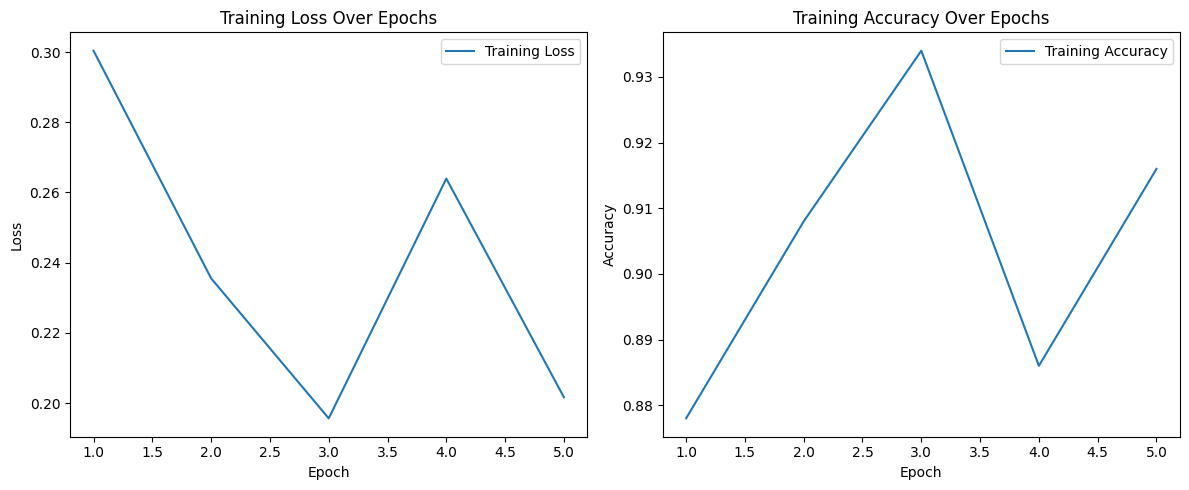

In [43]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
